In [27]:
import sys
import os
from os import P_ALL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns
import logging
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import importlib

# **importing scripts**

In [28]:
sys.path.append('/content/drive/MyDrive/store-sales-analysis/scripts')
import Exploratory_data_analysis as EDA
#import model_building as model
importlib.reload(EDA)

<module 'Exploratory_data_analysis' from '/content/drive/MyDrive/store-sales-analysis/scripts/Exploratory_data_analysis.py'>

# **Logging file**

In [29]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging
logging.basicConfig(
    filename="/content/drive/MyDrive/store-sales-analysis/pipeline/ml_pipeline.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

# **Loading Datasets**

In [30]:
file_path_train = '/content/drive/MyDrive/store-sales-analysis/data/train.csv'
file_path_test = '/content/drive/MyDrive/store-sales-analysis/data/test.csv'
file_path_store = '/content/drive/MyDrive/store-sales-analysis/data/store.csv'

train = EDA.load_data(file_path_train)
test = EDA.load_data(file_path_test)
store = EDA.load_data(file_path_store)
logging.info('Data loaded successfully')

/content/drive/MyDrive/store-sales-analysis/scripts/Exploratory_data_analysis.py:22: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


data loaded successfully.
data loaded successfully.
data loaded successfully.


# **Summerize Datasets**

In [31]:
logging.info("Starting data processing...")
for df in [train, test, store]:
    EDA.summarize_data(df)


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None

 First 5 Rows:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1      

In [32]:
for df in [train,test, store]:
    print(df.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')
Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


# **Handling missing values**

In [33]:
for df in [train, test, store]:
    EDA.handle_missing_values(df)

Missing values handled successfully.
Missing values handled successfully.
Missing values handled successfully.


# **Handling Outliers**

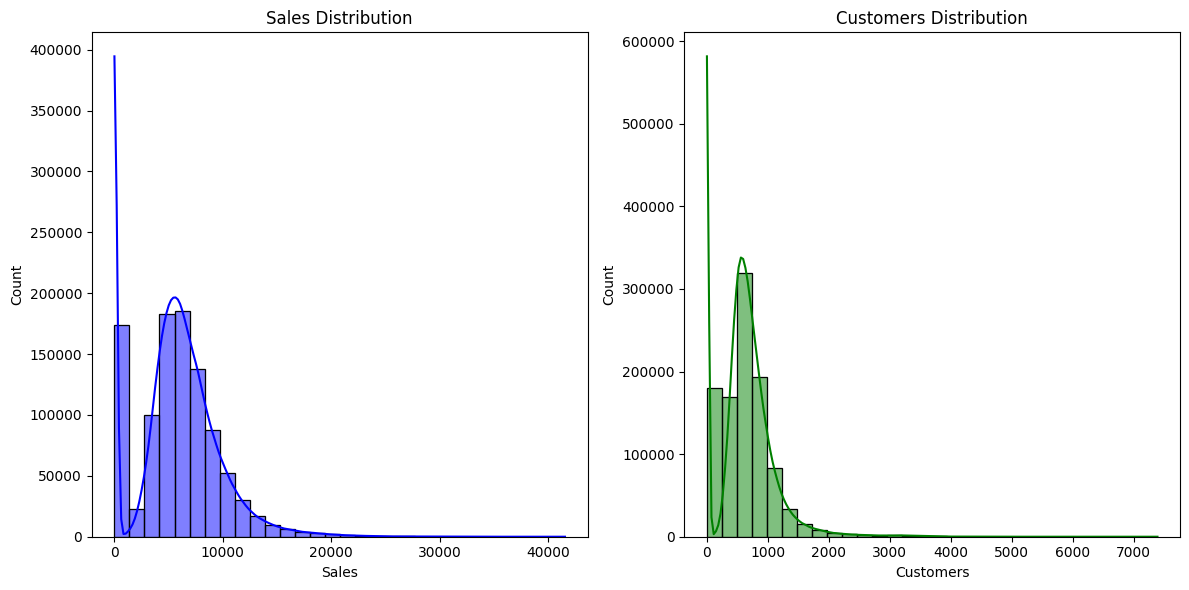

In [35]:
for col in ['Sales', 'Customers']:
    EDA.remove_outliers(train, col)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the second subplot (index 1)
sns.histplot(train[col], kde=True, bins=30, ax=axes[1], color="green")
axes[1].set_title(f"{col} Distribution")

sns.histplot(train['Sales'], kde=True, bins=30, ax=axes[0], color="blue")
axes[0].set_title(f"Sales Distribution")

plt.tight_layout()
plt.show()

# **Correlation**

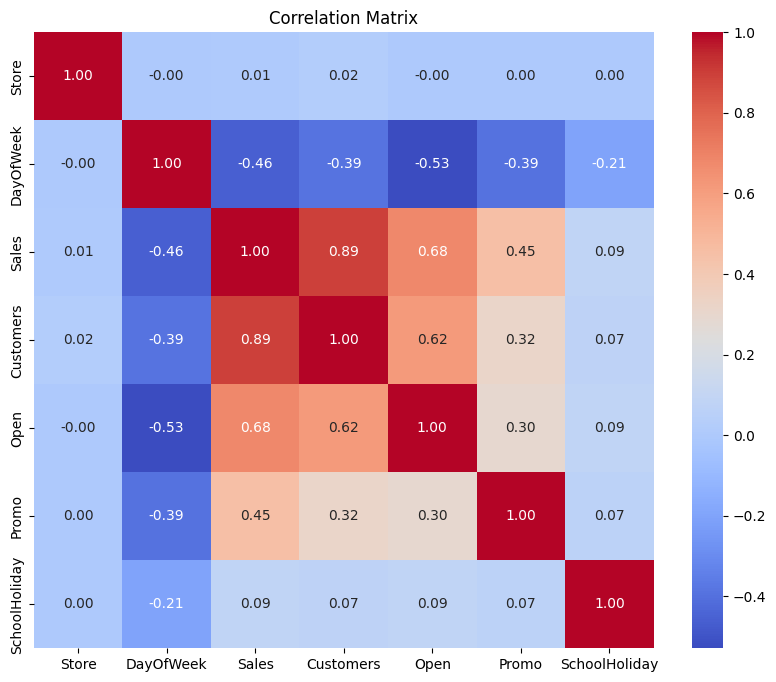

In [36]:
EDA.plot_correlation_matrix(train)

In [37]:
logging.info('starting trend analysis')

# **Analyze sales trend**

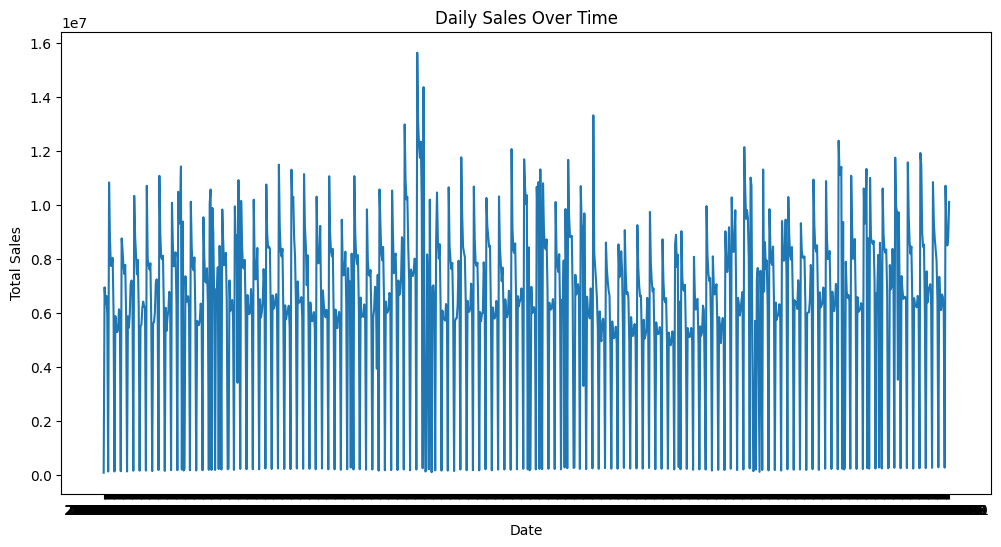

In [38]:
daily_sales = train.groupby('Date')['Sales'].sum()
plt.figure(figsize=(12, 6))
plt.plot(daily_sales)
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# **Effect of Promotions on Sales**

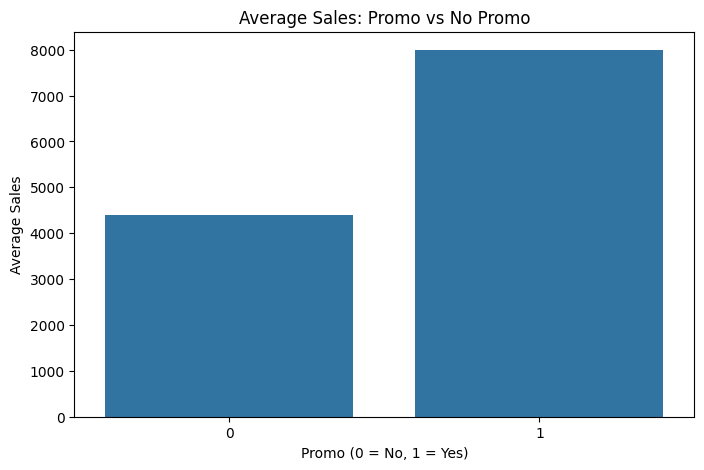

In [39]:
promo_sales = train.groupby('Promo')['Sales'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=promo_sales.index, y=promo_sales.values)
plt.title('Average Sales: Promo vs No Promo')
plt.xlabel('Promo (0 = No, 1 = Yes)')
plt.ylabel('Average Sales')
plt.show()

# **Effect of Store Openings on Customers**

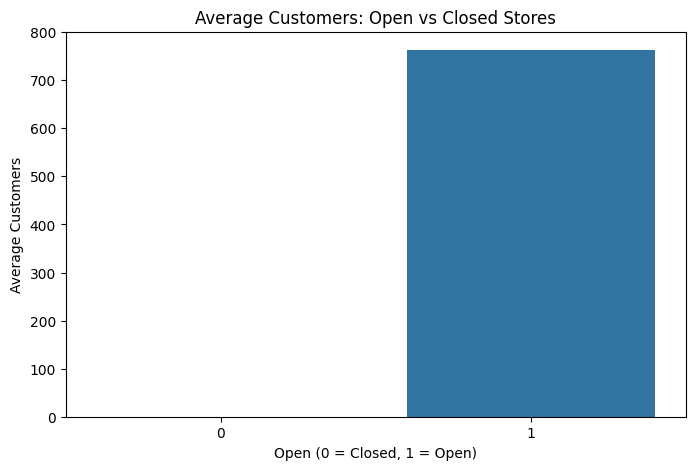

In [40]:
open_customers = train.groupby('Open')['Customers'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=open_customers.index, y=open_customers.values)
plt.title('Average Customers: Open vs Closed Stores')
plt.xlabel('Open (0 = Closed, 1 = Open)')
plt.ylabel('Average Customers')
plt.show()

# **Variability with Sales**

<ipython-input-41-476deeece870>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x='Promo', y='Sales', palette='viridis')


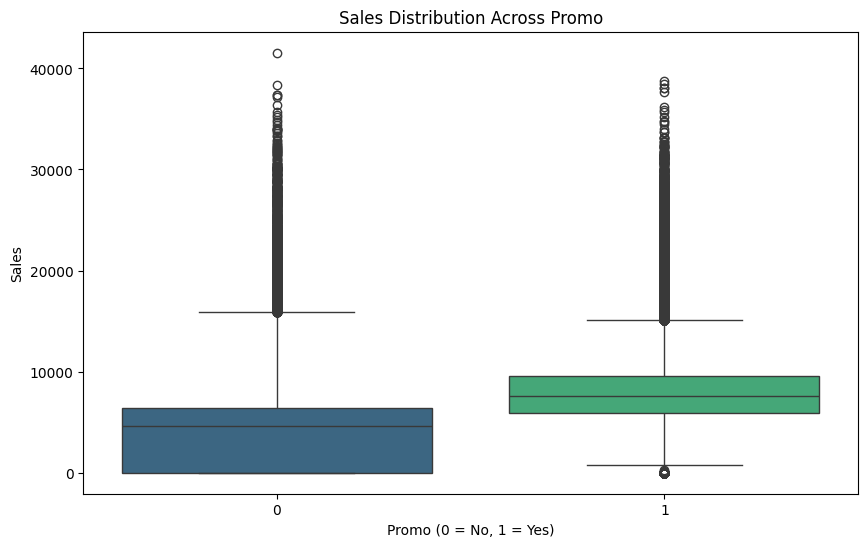

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='Promo', y='Sales', palette='viridis')
plt.title('Sales Distribution Across Promo')
plt.xlabel('Promo (0 = No, 1 = Yes)')
plt.ylabel('Sales')
plt.show()

# **Observations**

Sales increase significantly during promotions.

Open stores naturally have higher customer counts.

The correlation matrix reveals relationships among features, especially with Sales.

The box is wider and outliers are more frequent for no promo.

Variability is low, the box is narrow and there are fewer outliers for promo.

# **comparions of promotion distributions between test and train data**

In [42]:
train_promotions = train['Promo'].value_counts(normalize=True)
test_promotions = test['Promo'].value_counts(normalize=True)

print("Training Set Promotion Distribution:\n", train_promotions)
print("\nTest Set Promotion Distribution:\n", test_promotions)

Training Set Promotion Distribution:
 Promo
0    0.618485
1    0.381515
Name: proportion, dtype: float64

Test Set Promotion Distribution:
 Promo
0    0.604167
1    0.395833
Name: proportion, dtype: float64


# **Sales behavior before, during, and after holidays**

Average sales before, during, and after holidays:
 HolidayPeriod
During Holiday    4812.277351
After Holiday     5833.178661
Regular Day       5873.472416
Before Holiday    6681.326613
Name: Sales, dtype: float64


<ipython-input-43-c862615d3a45>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette="viridis")


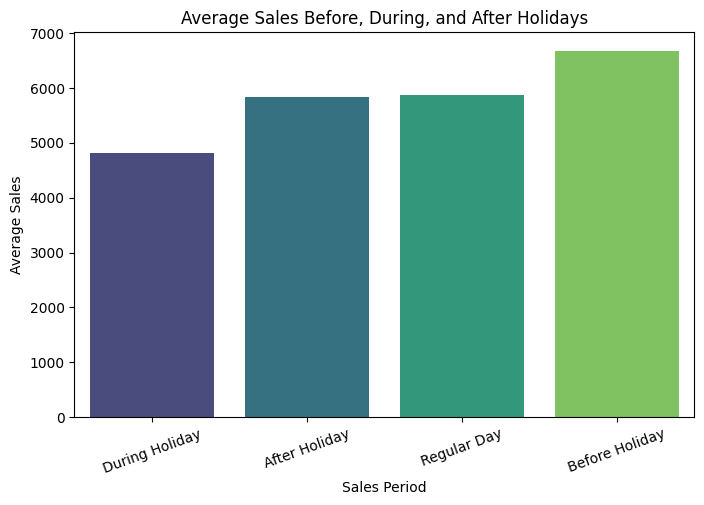

In [43]:
# Convert Date to datetime format
train['Date'] = pd.to_datetime(train['Date'])

# Define a function to classify sales periods
def classify_holiday_period(date, holidays):
    if date in holidays:
        return "During Holiday"
    elif any(abs((date - h).days) <= 3 for h in holidays if date < h):
        return "Before Holiday"
    elif any(abs((date - h).days) <= 3 for h in holidays if date > h):
        return "After Holiday"
    else:
        return "Regular Day"

# Identify unique holiday dates
holiday_dates = train.loc[train['StateHoliday'] != '0', 'Date'].unique()

# Create a new column for sales period classification
train['HolidayPeriod'] = train['Date'].apply(lambda x: classify_holiday_period(x, holiday_dates))

# Group by Holiday Period
holiday_sales = train.groupby('HolidayPeriod')['Sales'].mean().sort_values()

# Print average sales in each period
print("Average sales before, during, and after holidays:\n", holiday_sales)

# Visualize with a bar plot
plt.figure(figsize=(8,5))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette="viridis")
plt.title("Average Sales Before, During, and After Holidays")
plt.ylabel("Average Sales")
plt.xlabel("Sales Period")
plt.xticks(rotation=20)
plt.show()

# **Key Insights**
**Before Holidays → Highest Increase (6681.326613)**

Customers are likely shopping in advance for the holiday.

Promotions or sales events might be driving demand.

**During Holidays → Sales Drop (4812.277351)**

This suggests that stores might be closed or less busy on actual holidays.

Customers could have already completed their shopping before the holiday.

**After Holidays → Slight Increase (5833.178661)**

Some people may return to shopping (e.g., clearance sales, returns, or post-holiday promotions).

The increase is small, so it doesn’t strongly impact overall sales.

**Regular Days → Moderate Sales (5873.472416)**

## **Promo impact on sales and customers**

In [44]:
# Group by 'Promo' and calculate average Sales and Customers
promo_sales = train.groupby('Promo')[['Sales', 'Customers']].mean()
print("Promo impact on Sales and Customers:\n", promo_sales)

Promo impact on Sales and Customers:
              Sales   Customers
Promo                         
0      4406.050805  517.823542
1      7991.152046  820.098815


# **Insights**
Sales increase significantly during promotions (4406.050805 to 517.823542).

More customers shop during promotions (7991.152046 to 820.098815).

# **Effective promo deployment by store**

In [45]:
promo_by_store = train.groupby('Store')['Promo'].sum().sort_values(ascending=False)
top_promo_stores = promo_by_store.head(10)
print("Top 10 stores with the most promotions:\n", top_promo_stores)

Top 10 stores with the most promotions:
 Store
1115    360
1       360
2       360
3       360
4       360
5       360
6       360
7       360
8       360
9       360
Name: Promo, dtype: int64


# **Stores open all weekdays and their weekend sales**

Comparison of Weekday and Weekend Sales:
        Weekday Sales  Weekend Sales
Store                              
1        4531.893175    2471.485075
2        5191.189911    1436.552239
3        7142.461424    2217.320896
4        9200.749258    5056.723881
5        4991.421365    1039.552239
...              ...            ...
1111     5416.004451    1644.361940
1112    10123.017804    4296.194030
1113     6537.838279    2946.787313
1114    19678.379822   10967.750000
1115     5956.372404    3386.694030

[1115 rows x 2 columns]


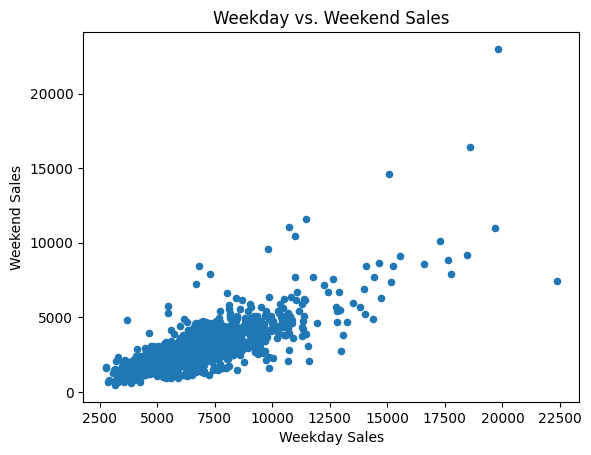

In [46]:
weekday_sales = train[train['DayOfWeek'] <= 5].groupby('Store')['Sales'].mean()
weekend_sales = train[train['DayOfWeek'] > 5].groupby('Store')['Sales'].mean()

comparison = pd.DataFrame({'Weekday Sales': weekday_sales, 'Weekend Sales': weekend_sales})
print("Comparison of Weekday and Weekend Sales:\n", comparison)
comparison.dropna().plot(kind='scatter', x='Weekday Sales', y='Weekend Sales')
plt.title("Weekday vs. Weekend Sales")
plt.show()

# **Key Insights from a Scatter Plot**
**Sales Patterns**

weekday sales are higher, it suggests peak shopping happens during the workweek.

# **Merging store dataset and train dataset to do store analysis**

In [47]:
store.set_index('Store', inplace=True)
train.set_index('Store', inplace=True)

# Join DataFrames
df = store.join(train, how='inner')
print(df.head())

      StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
Store                                                                        
1             c          a               1270.0                        9.0   
1             c          a               1270.0                        9.0   
1             c          a               1270.0                        9.0   
1             c          a               1270.0                        9.0   
1             c          a               1270.0                        9.0   

       CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
Store                                                                       
1                        2008.0       0              NaN              NaN   
1                        2008.0       0              NaN              NaN   
1                        2008.0       0              NaN              NaN   
1                        2008.0       0              NaN            

# **Assortment type effect on sales**

Sales by Assortment Type:
 Assortment
a    5481.026096
b    8553.931999
c    6058.676567
Name: Sales, dtype: float64


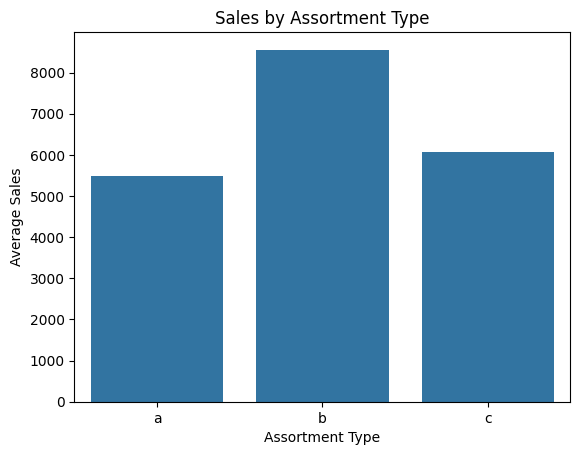

In [48]:
assortment_sales = df.groupby('Assortment')['Sales'].mean()
print("Sales by Assortment Type:\n", assortment_sales)

sns.barplot(x=assortment_sales.index, y=assortment_sales.values)
plt.title("Sales by Assortment Type")
plt.ylabel("Average Sales")
plt.xlabel("Assortment Type")
plt.show()

# **Interpretation:**
**Assortment a:**

Sales have a correlation of 5481.026096, suggesting that stores with assortment type 'a' may experience slightly lower sales on average.

**Assortment b:**

 Sales for assortment type 'b' have a correlation of 8553.931999, indicating that stores with assortment type 'b' tend to have significantly higher sales on average.

**Assortment c:**

Sales for assortment type 'c' have a small correlation of 6058.676567, indicating a very slight increase in sales, but it's not as pronounced as for assortment 'b'.

# **Top store sales**

In [49]:
top_sales_stores = df.groupby('Store')['Sales'].sum().sort_values(ascending=False).head(10)
print("Top 10 Stores by Total Sales:\n", top_sales_stores)

Top 10 Stores by Total Sales:
 Store
262     19516842
817     17057867
562     16927322
1114    16202585
251     14896870
513     14252406
788     14082141
733     14067158
383     13489879
756     12911782
Name: Sales, dtype: int64


# **Promotional Effectiveness**

In [50]:
promo_effect = df.groupby('Promo')['Sales'].mean()
print("Average Sales with and without Promotions:\n", promo_effect)

Average Sales with and without Promotions:
 Promo
0    4406.050805
1    7991.152046
Name: Sales, dtype: float64


**Interpretation:**

**Without Promotion (Promo = 0):**

Sales have a negative correlation of 4406.050805, suggesting that, on average, sales without a promotion are slightly lower.

**With Promotion (Promo = 1)**:

 Sales have a positive correlation of 7991.152046, indicating that, on average, promotions lead to a significant increase in sales.

# **Holiday sales**

In [51]:
holiday_sales = df.groupby('StateHoliday')['Sales'].mean()
print("Average Sales by Holiday Type:\n", holiday_sales)

Average Sales by Holiday Type:
 StateHoliday
0    5733.530624
0    5980.279717
a     290.735686
b     214.311510
c     168.733171
Name: Sales, dtype: float64


# **insights**
Sales are low during state holidays

In [52]:
logging.info('data exploring completed')
logging.info('Starting model building')

# **Standard Scaler**

**Checks skewness and applies transformation if data is highly skewed**

Right-Skewed (0.6415) detected. Applying log transformation.
Data is still highly skewed. Applying Power Transformation.


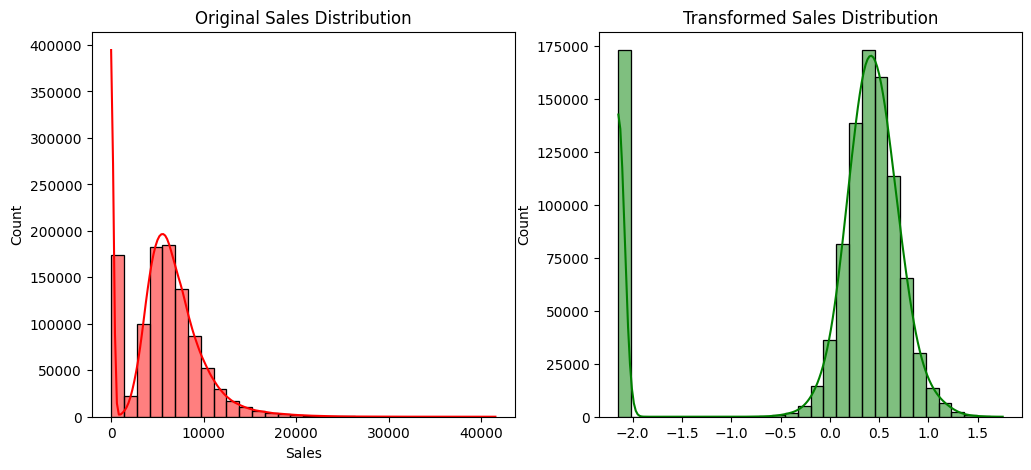

In [54]:
df['Sales'] = EDA.handle_skewness(df,'Sales')

In [55]:
#save df for future use
data = df.to_csv('/content/drive/MyDrive/store-sales-analysis/data/data.csv')